# Sequential decision making with discrete state and action spaces

### Sudip Das

#### Import the necessary libraries:

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import itertools
import datetime
import random
%matplotlib inline


#### Design a maze:

In [2]:
def get_maze(maze_file):
    '''
    para1: filename of the maze txt file
    return mazes as a numpy array walls: 0 - no wall, 1 - wall
    '''
    a = open(maze_file, 'r')  
    m=[]
    for i in a.readlines():
        m.append(np.array(i.split(" "), dtype="int32"))
    return np.array(m)

In [3]:
# State Space
S=get_maze("my_maze_25X25.txt")  
START = (1,1)
GOAL = (24,24)
# Action Space
A = [
    (-1, 0),    # 'up'
    (1, 0),     # 'down'
    (0, -1),    # 'left'
    (0, 1),     # 'right'
    (0, 0)      # 'stay'
]


# Noise
ALPHA = [0.2, 0.8]

max_it = 100
print(S[0][0])

1


In [4]:
GRID_SIZE = len(S)
# goal state
S[GOAL] = 3

### Visualize the maze:

In [5]:
print(S)

[[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 1]
 [1 0 1 1 1 1 1 0 1 1 1 1 1 0 1 0 1 0 0 0 1 0 0 1 0 1]
 [1 0 0 0 0 0 1 0 1 0 0 0 0 0 1 0 1 0 0 0 0 0 0 1 0 1]
 [1 1 1 1 1 0 1 0 1 1 1 1 1 1 1 0 1 1 1 0 1 1 1 1 0 1]
 [1 0 0 0 1 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 1]
 [1 0 0 0 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 0 0 0 0 1]
 [1 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 1 1 1 1 0 1]
 [1 0 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 0 1 0 0 0 0 1 0 1]
 [1 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 1 1 1 1 0 1]
 [1 0 1 1 1 0 1 1 1 1 1 1 1 0 1 1 1 1 1 0 0 0 0 0 0 1]
 [1 0 0 0 0 0 0 0 0 1 0 0 1 0 0 0 0 0 0 0 1 1 1 1 0 1]
 [1 0 1 1 1 1 1 1 1 0 1 0 1 1 1 0 1 0 1 0 1 0 0 1 0 1]
 [1 0 1 0 0 0 0 0 1 0 1 0 0 0 1 0 1 0 1 0 1 0 0 0 0 1]
 [1 0 1 0 1 0 1 1 1 0 1 1 1 0 1 1 1 0 1 1 1 0 1 1 1 1]
 [1 0 1 0 1 0 1 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 1 0 1]
 [1 0 1 0 1 1 1 0 1 1 1 0 1 0 1 1 1 0 0 1 1 1 0 1 0 1]
 [1 0 1 0 0 0 0 0 0 0 0 0 1 0 1 0 1 0 0 0 0 1 0 0 0 1]
 [1 0 1 1 

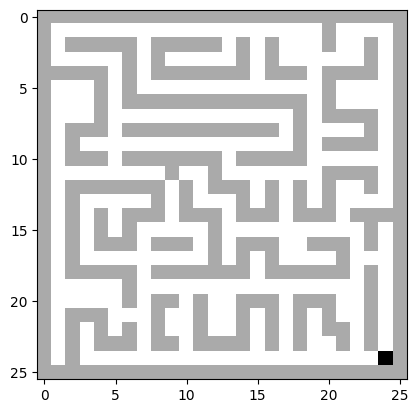

In [6]:
plt.imshow(S, cmap='binary')

In [94]:
def s_next_calc(s, a):
    '''This function returns the agent's next state given action
    and current state (assuming the action succeeds).
    : param s: Current position of the agent
    : param a: action taken by the agent
    : returns: New state coordinates in the grid
    '''
    
    return (s[0] + A[a][0], s[1] + A[a][1])

In [95]:
def hit_wall(curr, action):
    '''This function checks if the agent hits any walls. Agent calculates "hitting the wall"
    with deterministic dynamics
    : param curr: Current position of the agent
    : param action: Chosen action by the agent
    : returns: True/False Binary value to indicate if agent hits a wall
    '''
    s_new = (
        curr[0] + A[action][0],
        curr[1] + A[action][1]
    )

    # Check for grid boundaries
    if min(s_new) < 0 or max(s_new) > GRID_SIZE-1:
        return True

    # Check walls
    # 0: 'up':   (-1,  0),
    # 1: 'down': ( 1,  0),
    # 2: 'left': ( 0, -1),
    # 3: 'right':( 0,  1),
    # 4: 'stay': ( 0,  0)
    if (S[curr]==0 and S[s_new]==1):
        return True

    return False

#### Reward function

In [96]:
def R(s, a):
    '''Reward function
    : param s: Current state of the agent
    : param a: Action the agent takes at the current state
    : returns: Reward for the action at current state
    '''
    if s == GOAL:
        return 0
    elif hit_wall(s, a):
        return -10000
    else:
        return -1

#### Transition probabilities to state s_next from current state s upon action a:

In [97]:
def Pr(s_next, s, a, alpha):
    '''This function returns probabilities for each action at agent's
    current state.
    :param s: Current state of the agent
    :param a: Action the agent takes at the current state
    :param alpha: Probability of the agent to take a random action instead of the action a
    :returns : Transition probability for the action at current state
    '''
    # can't move once reached the GOAL
    if s == GOAL:
        if s_next == s:
            return 1
        else:
            return 0

    # If wall hit, next state is current state 
    if hit_wall(s, a):
        # Legal action with s = s'
        if s_next == s:
            return 1
        # Illegal action with s != s'
        else:
            return 0

    # Legal action with adjacent s and s'
    if s_next == s_next_calc(s, a):
        return 1 - alpha
    else:
        # Agent moves to another adjacent state instead of s' due to noise in a.
        # Generate all other neighbors of s by applying actions other than a.
        other_s_next = [s_next_calc(s, i)
                    for i in range(len(A)) if i is not a]
        if s_next in other_s_next:
            return alpha/4
    return 0

### Policy Iteration


In [98]:
def policy_evaluation(policy, S, Pr, alpha, discount, theta, ctr):

    V = np.zeros((GRID_SIZE, GRID_SIZE))
    V_prev = np.zeros((GRID_SIZE, GRID_SIZE))
 
    for _ in range(ctr):
        # chose an initial delta value for the convergence test
        delta = 0
        V_prev = V.copy()
        for s, _ in np.ndenumerate(S):
            
            # action by the policy
            a = policy[s]
            # update value function for the state s
            V[s] = R(s, a)
            for i in range(len(A)):
              if not hit_wall(s, i):
                s_next = s_next_calc(s, i)
                V[s] += discount * V_prev[s_next] * Pr(s_next, s, a, alpha)
            # convergece test
            delta = max(delta, abs(V[s] - V_prev[s]))
                            
        if delta < theta: break
    
    return V, delta

In [6]:
def policy_improvement(V, S, A, Pr, alpha, discount):

    policy = np.zeros((GRID_SIZE, GRID_SIZE), dtype=int)
    policy_stable = True
        
    for s, _ in np.ndenumerate(S):
            
        old_action = policy[s]
        Q = np.zeros(len(A))
        for a in range(len(A)):
            Q[a] = R(s, a)
            for i in range(len(A)):
              if not hit_wall(s, i):
                s_next = s_next_calc(s, i)
                Q[a] += discount * Pr(s_next, s, a, alpha) * V[s_next]

        # update policy at state s
        policy[s] = np.argmax(Q)

        if old_action != policy[s]: policy_stable = False
    
    return policy, policy_stable

In [7]:
def policy_iteration(S, A, Pr, alpha, discount, theta, n_eval, plot_enable, plot=None):
    """
    :param list S: set of states
    :param list A: set of actions
    :param function Pr: transition function
    :param float alpha: noise 
    :param float discount: discount factor
    :param float theta: tolerance, which determines when to end iterations
    :param int n_eval: number of evaluations
    :param plot: list of iteration numbers to plot
    """
    
    epsilon = 0
    
    start_time = 0
    end_time = 0
    time = 0
    total_time = 0
    
    plt.ion()
    policy = np.random.randint(0, len(A), (GRID_SIZE, GRID_SIZE))
    count=0
    
    while True:
                
        start_time = datetime.datetime.now() # For Task 4
        
        V, delta = policy_evaluation(policy, S, Pr, alpha, discount, theta, n_eval)
        policy , policy_stable = policy_improvement(V, S, A, Pr, alpha, discount)

        
        end_time = datetime.datetime.now()
        time = (end_time - start_time).total_seconds() # calculate time taken [seconds] for one iteration
        total_time += time
      
        # plot intermediate result
        if (plot and count+1 in plot) and plot_enable:
            plot_value_grid(V, policy, msg='Policy iteration, alpha = {}, discount = {}, iteration = {}'.format(alpha, discount, count+1))
        
        if delta == 0:
            if plot_enable :
                plot_value_grid(V, policy, msg='Policy iteration, alpha = {}, discount = {}, iteration = {}'.format(alpha, discount, count+1))
            break
                
        if (delta > 0 and delta<=epsilon) or count==max_it or policy_stable:    
            if(count == max_it):
                print('Policy iteration failed to converge for alpha = {}, discount = {}, iteration = {}'.format(alpha, discount, count+1))
            if(plot_enable):
                 plot_value_grid(V, policy, msg='Policy iteration, alpha = {}, discount = {}, iteration = {}'.format(alpha, discount, count+1))
            break
        count=count+1

    return V, policy, count, total_time


### Value Iteration


In [8]:
def value_iteration(S, A, Pr, alpha, discount, plot_enable, plot=None):
    """
    :param list S: set of states
    :param list A: set of actions
    :param function Pr: transition function
    :param float alpha: noise
    :param float discount: discount factor
    """

    start_time = 0
    end_time = 0
    time = 0
    total_time = 0
    
    plt.ion()

    V = np.zeros((GRID_SIZE, GRID_SIZE))
    V_prev = np.zeros((GRID_SIZE, GRID_SIZE))
    optimal_policy = np.random.randint(0, len(A), (GRID_SIZE, GRID_SIZE), dtype=int)

    count=0
    while True:
        
        start_time = datetime.datetime.now() # For Task 4
    
        delta = 0 
        V_prev = V.copy()
        
        for s,_ in np.ndenumerate(S):
                    
            Q = np.zeros(len(A))
            for a in range(len(A)):
                Q[a] = R(s,a) # expression for the Q function at state, s, and action, a
                for i in range(len(A)):
                    if not hit_wall(s, i):
                        s_next = s_next_calc(s, i)
                        Q[a] += discount * Pr(s_next, s, a, alpha) * V_prev[s_next]
            V[s] = np.max(Q)
            delta = max(delta, abs(V[s] - V_prev[s])) # set the validation condition for the convergence
            
            optimal_policy[s] = np.argmax(Q)
        
        end_time = datetime.datetime.now()
        time = (end_time - start_time).total_seconds() # calculate time taken [seconds] for one iteration
        total_time += time
        
        # plot current value and optimal policy
        if (plot and count+1 in plot) and plot_enable:
            plot_value_grid(V, optimal_policy, msg='Value iteration, alpha = {}, discount = {}, iteration = {}'.format(alpha, discount, count+1))
            plt.pause(0.1)
        if delta <= 0 or count==max_it: 
            if count == max_it:
                print('Value iteration failed to converge for alpha = {}, discount = {}, iteration = {}'.format(alpha, discount, count+1))
            if(plot_enable):
                plot_value_grid(V, optimal_policy, msg='Value iteration, alpha = {}, discount = {}, iteration = {}'.format(alpha, discount, count+1))
                plt.pause(0.1)
            break
        count=count+1
    return V, optimal_policy, count, total_time


In [9]:
def plot_value_grid(V, policy, msg=""):
    fig = plt.figure(figsize=(5, 5), tight_layout=True)
    plt.title(msg)
    plt.imshow(V)
   
    quiver_action_dict = [
            [1, 0],
            [-1, 0],
            [0, -1],
            [0, 1],
            [0, 0]
    ]
    for k, a in np.ndenumerate(policy):
        if(S[k] == 0): # do not print the arrows on walls, to increase readibility
            q = plt.quiver(k[1], k[0], quiver_action_dict[a][1], quiver_action_dict[a][0])
    #fig.colorbar(q)
    plt.show()

### Optimal solution for $\alpha$ = 0 (no noise) using Policy Iteration

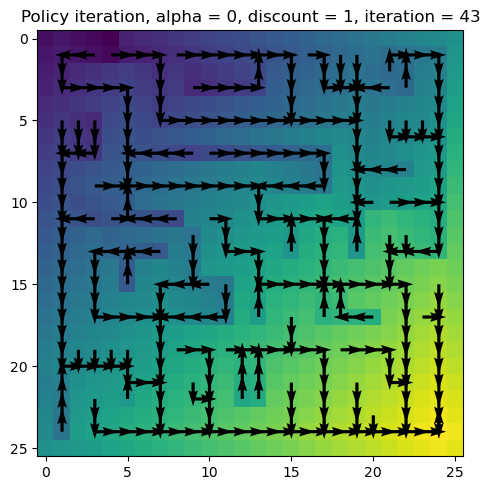

In [50]:
n_pol_eval = 100 #number of policy evalutions
val2, pol2, pol_max_iter, time_taken = policy_iteration(S, A, Pr, alpha=0, discount=1, theta = 1e-6, n_eval=n_pol_eval, plot_enable = True)


### Optimal solution for $\alpha$ = 0 (no noise) using Value Iteration

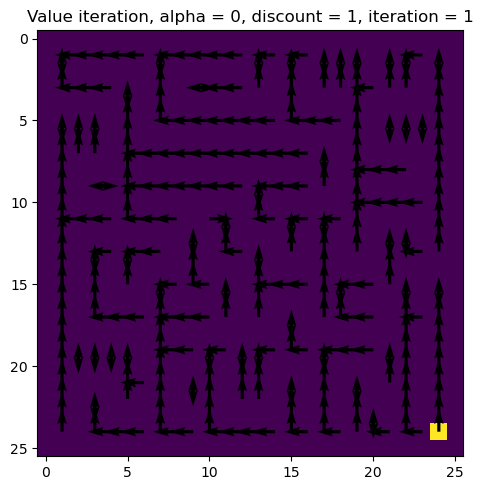

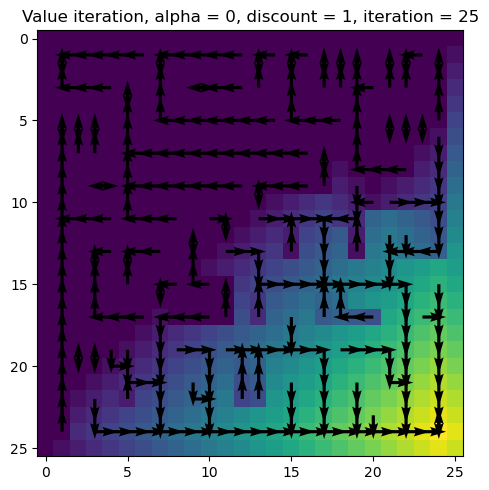

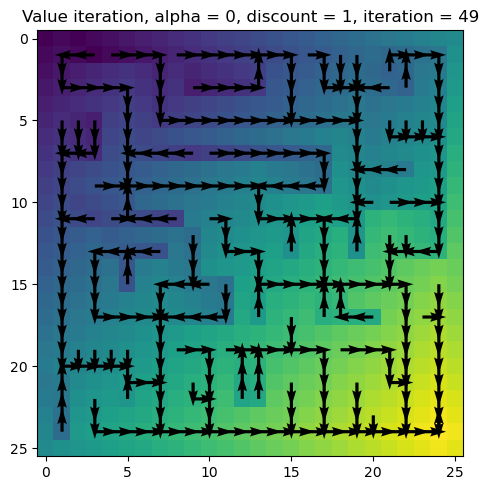

In [51]:

val1, pol1, val_max_iter, time_taken = value_iteration(S, A, Pr, alpha=0, discount=1, plot_enable=True, plot=[1, 25, 50, 100])


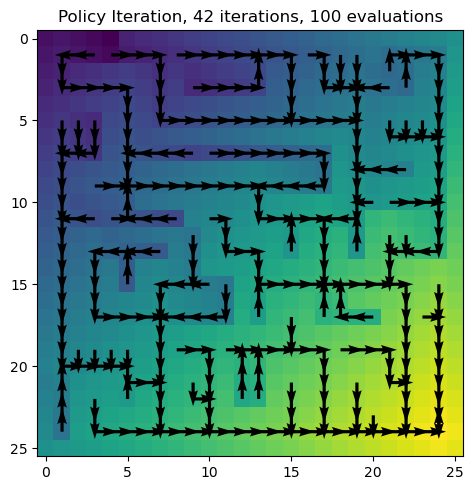

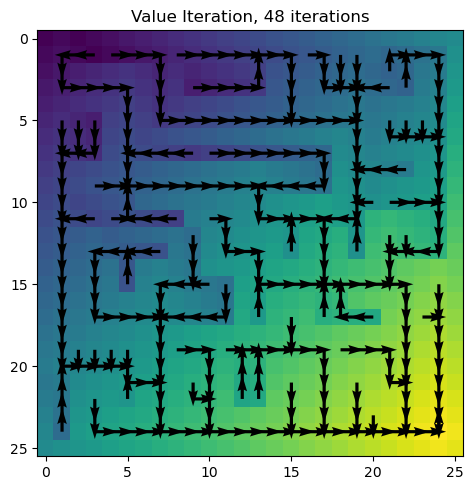

In [52]:
# Plot for policy iteration alpha = 0, k_max = 100, run for 100 iterations
plot_value_grid(val2, pol2, msg='Policy Iteration, {} iterations, {} evaluations'.format(pol_max_iter, n_pol_eval))
# Plot for value iteration alpha = 0, 100 iterations
plot_value_grid(val1, pol1, msg='Value Iteration, {} iterations'.format(val_max_iter))

### Policy Iteration for five different discounted factors $\gamma \in \{0, 0.1, 0.4, 0.9, 1\}$ 

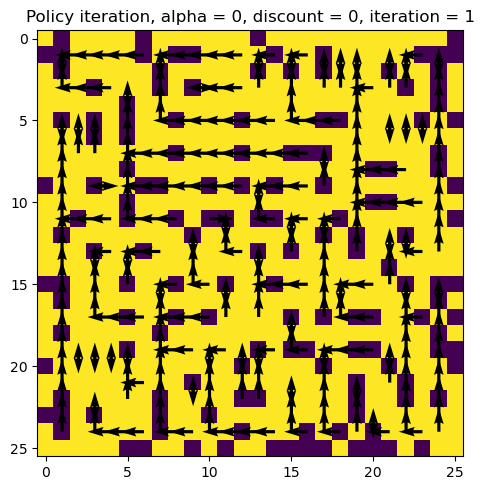

Policy iteration failed to converge for alpha = 0, discount = 0.1, iteration = 101


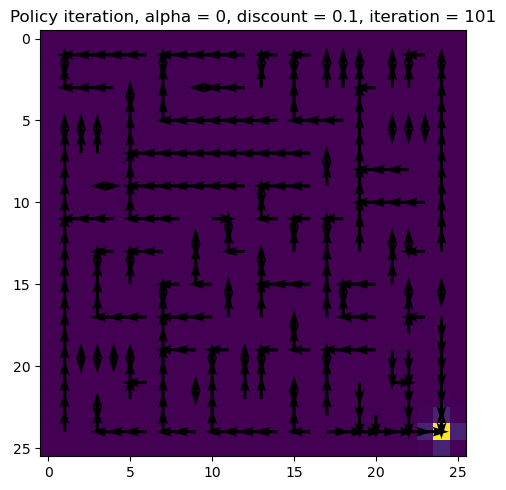

Policy iteration failed to converge for alpha = 0, discount = 0.4, iteration = 101


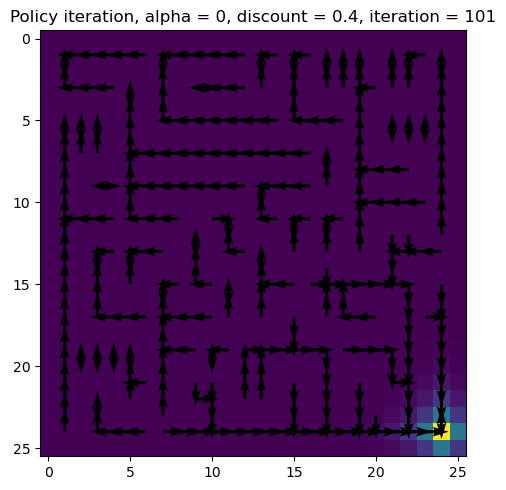

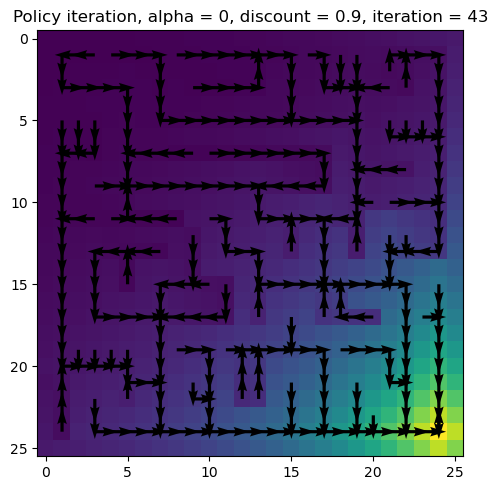

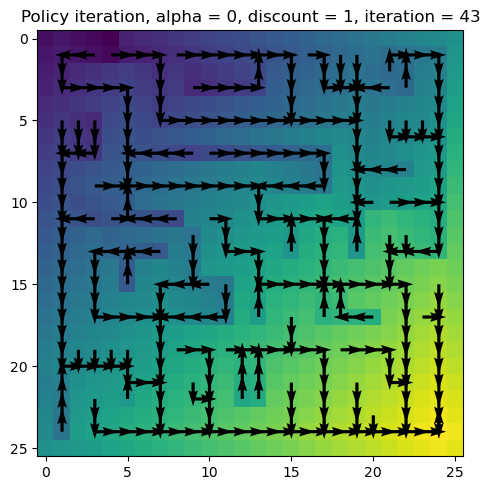

In [53]:
n_pol_eval = 100 #number of policy evalutions
pol_time_list = []
for gamma in [0,0.1,0.4,0.9,1] :  
    val2, pol2, pol_max_iter, comp_time = policy_iteration(S, A, Pr, alpha=0, discount=gamma, theta=1e-6, n_eval=n_pol_eval, plot_enable = True)
    pol_time_list.append(comp_time)
    plt.pause(0.1)

### Value Iteration for five different discounted factors $\gamma \in \{0, 0.1, 0.4, 0.9, 1\}$ 

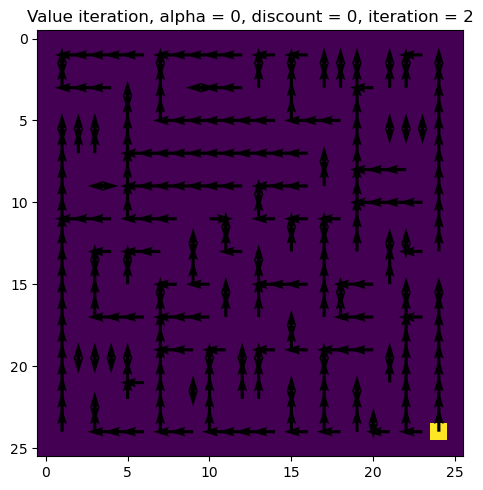

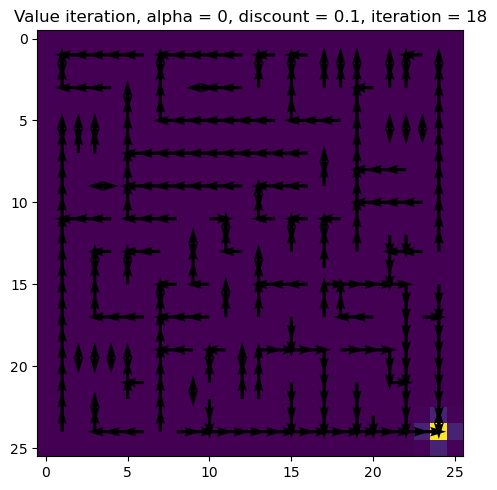

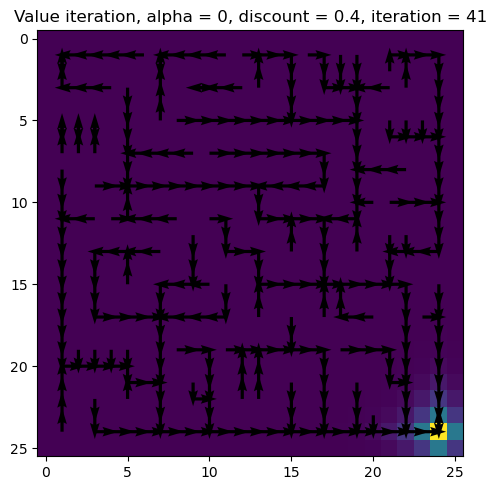

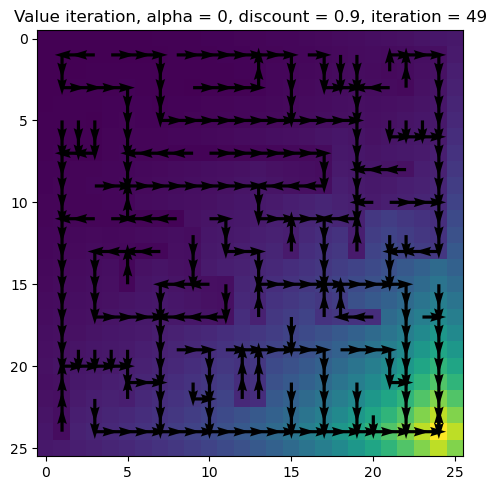

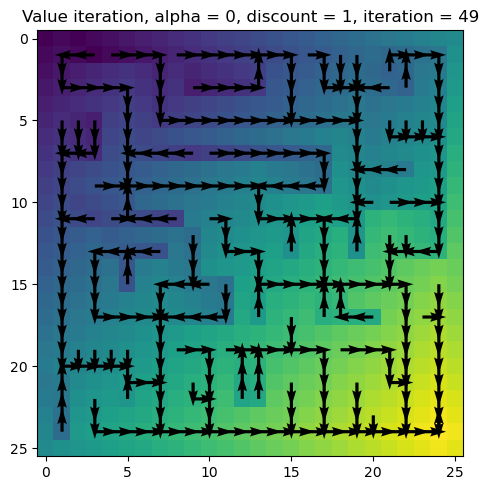

In [54]:
n_pol_eval = 100 #number of policy evalutions
val_time_list = []
for gamma in [0,0.1,0.4,0.9,1] :
    val1, pol1, val_max_iter, comp_time = value_iteration(S, A, Pr, alpha=0, discount=gamma, plot_enable=True, plot=None)
    val_time_list.append(comp_time)
    plt.pause(0.1)

### 𝛾 VS computational time for Policy iteration:

Text(0.5, 1.0, 'Discount VS Computational time for Policy iteration')

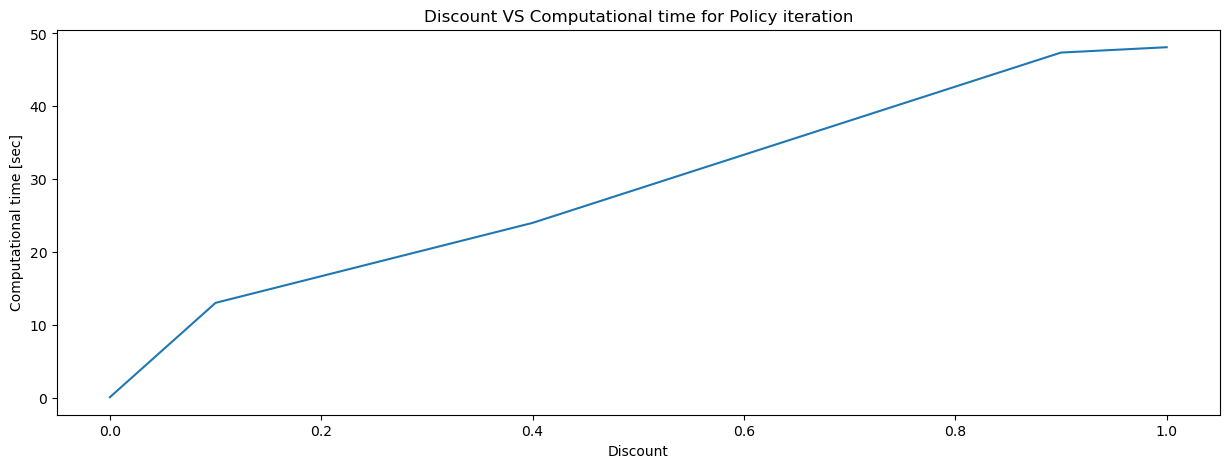

In [55]:
fig = plt.figure(figsize=(15,5))

plt.xlabel('Discount')
plt.ylabel('Computational time [sec]')
plt.plot([0,0.1,0.4,0.9,1], pol_time_list)
plt.title('Discount VS Computational time for Policy iteration')

### 𝛾 VS computational time for Value iteration:

Text(0.5, 1.0, 'Discount VS Computational time for Value iteration')

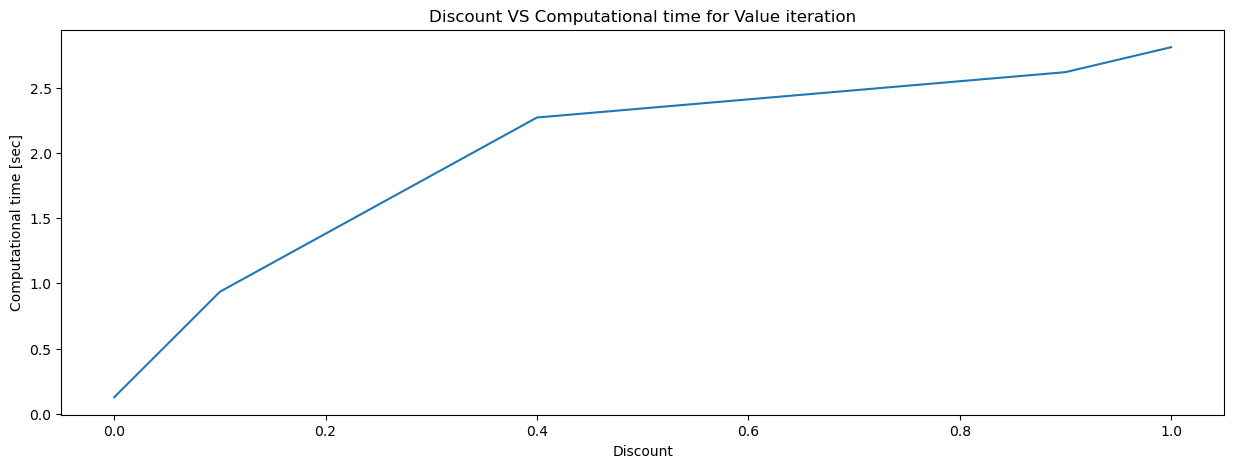

In [56]:
fig = plt.figure(figsize=(15,5))

plt.xlabel('Discount')
plt.ylabel('Computational time [sec]')
plt.plot([0,0.1,0.4,0.9,1], val_time_list)
plt.title('Discount VS Computational time for Value iteration')

### Value and Policy iteration for 10, 20 and 100 iterations with $\alpha \in \{0.2, 0.8\}$

#### I. Policy Iteration 

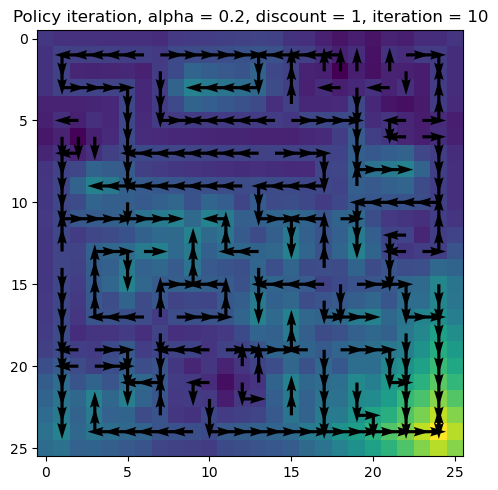

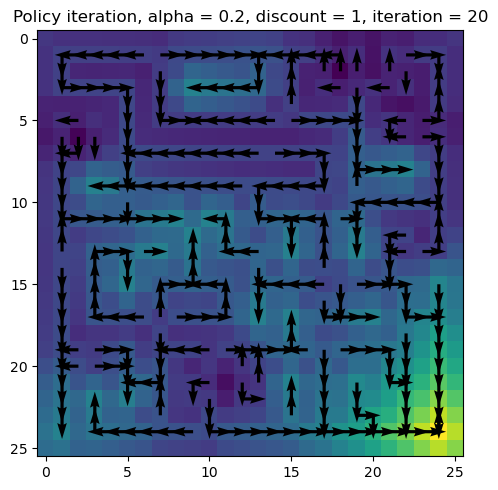

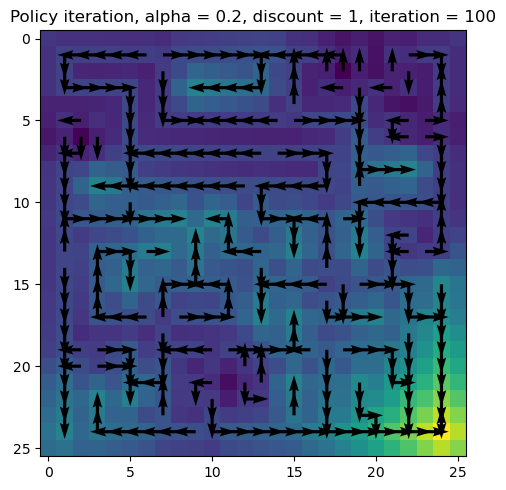

Policy iteration failed to converge for alpha = 0.2, discount = 1, iteration = 101


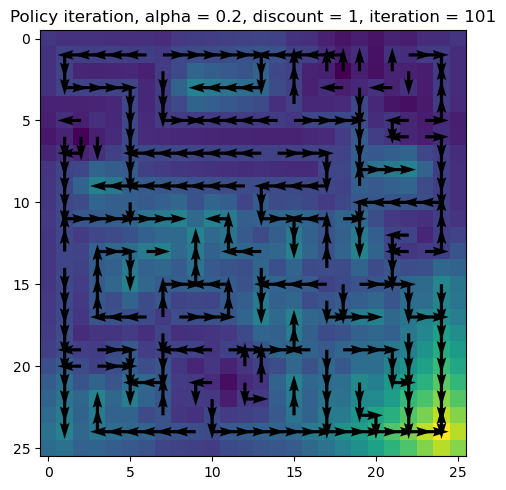

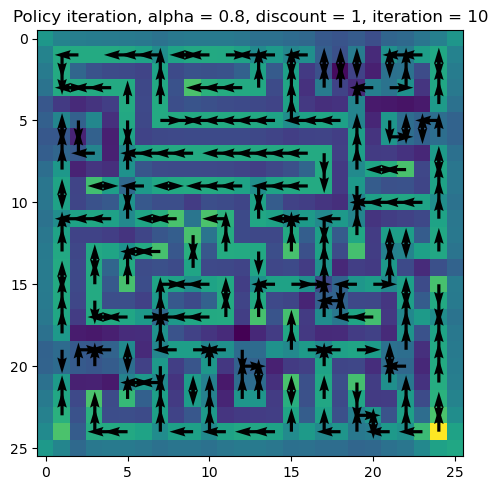

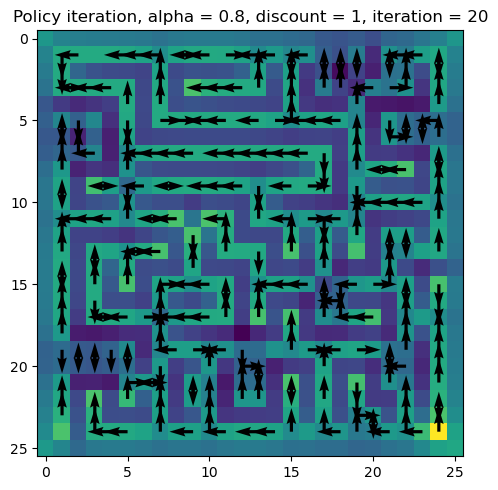

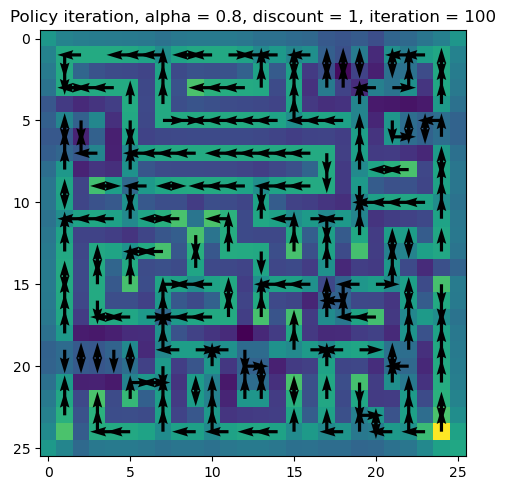

Policy iteration failed to converge for alpha = 0.8, discount = 1, iteration = 101


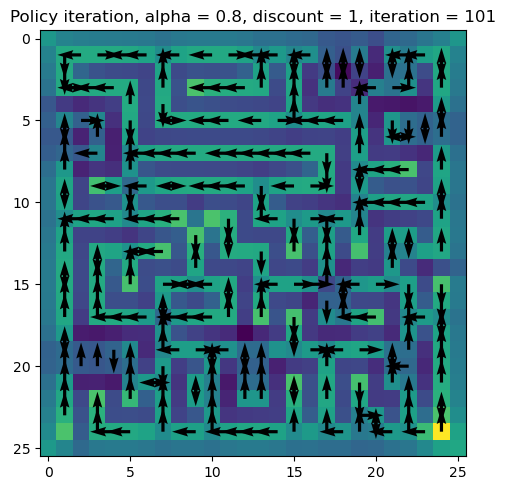

In [57]:
for idx1, alpha in enumerate(ALPHA):
    val, pol, pol_iter, time_taken = policy_iteration(S, A, Pr, alpha=alpha, discount = 1, theta=1e-6, n_eval=100, plot_enable = True, plot=[10, 20, 100])
    

#### II. Value Iteration

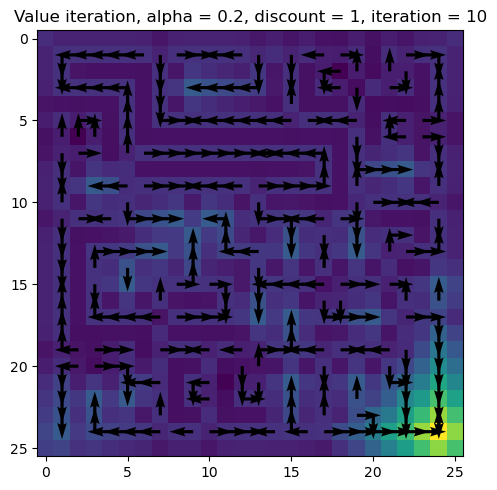

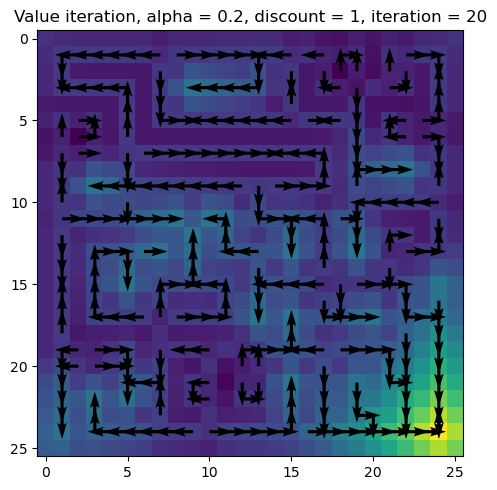

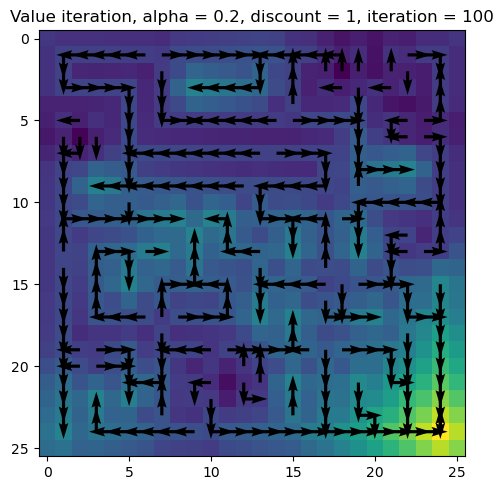

Value iteration failed to converge for alpha = 0.2, discount = 1, iteration = 101


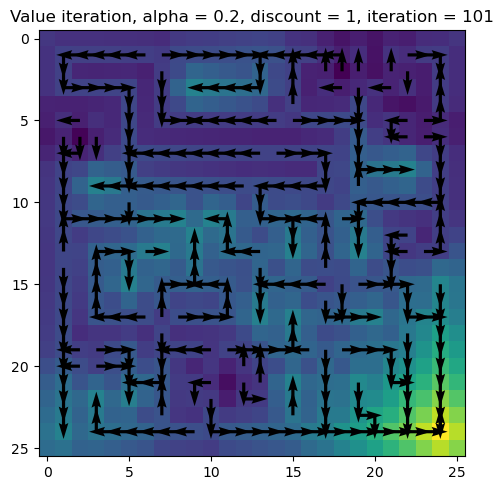

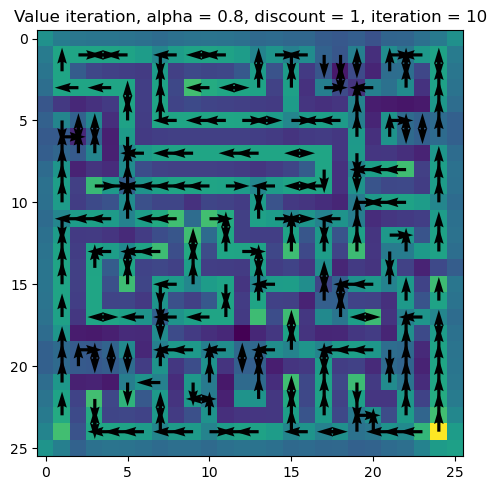

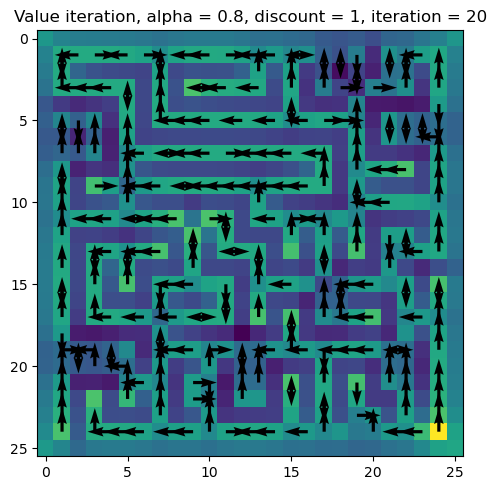

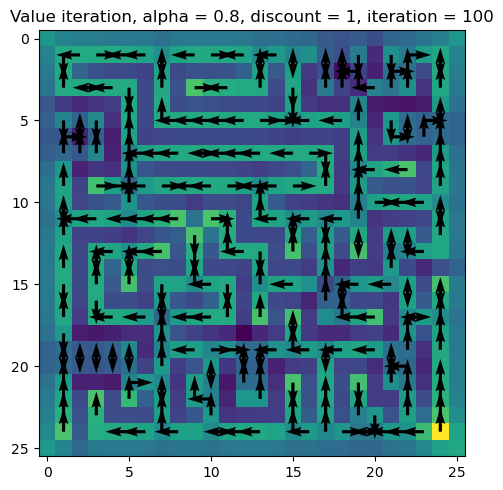

Value iteration failed to converge for alpha = 0.8, discount = 1, iteration = 101


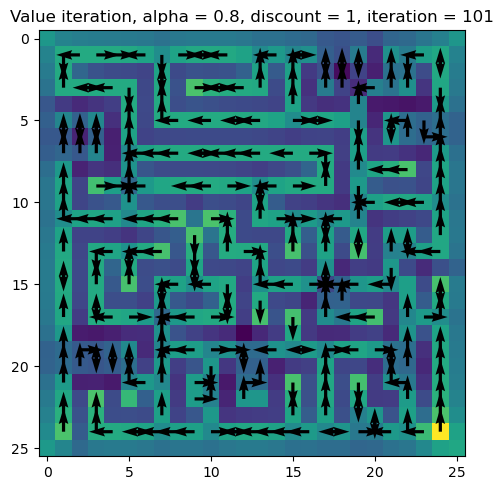

In [58]:
for idx1, alpha in enumerate(ALPHA):
    val, pol, val_iter, comp_time = value_iteration(S, A, Pr, alpha = alpha, discount = 1, plot_enable=True, plot=[10, 20, 100])
    